# Assignment 1

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchmetrics.classification import MulticlassConfusionMatrix

# local imports
from save_utils import save_model_config
from models import MLP, CNN, ConvMixer, count_model_params
from train import train
from visualize import plot_learning_curve, plot_images
from evaluate import evaluate
from schedulers import cosine_decay, LearningRateScheduler

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

Define constants and training parameters:

In [4]:
DATASET_PATH = './data'

BATCH_SIZE = 1024
SHUFFLE_TRAIN = True

NUM_EPOCHS = 100
LR = 1e-3

## Task 1

Train and compare the following models on the CIFAR-10 dataset (available in PyTorch). The models should have slightly optimized parameters to try to maximize their performance.

### Load dataset

In [21]:
train_dataset = datasets.CIFAR10(root=DATASET_PATH, train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root=DATASET_PATH, train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
CLASSES = train_dataset.classes

In [23]:
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=SHUFFLE_TRAIN
    )

eval_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        # drop_last=True
    )

### MLP

In [26]:
INPUT_DIM = np.prod(train_dataset.data.shape[-3:]) # 32*32*3
OUTPUT_DIM = len(set(train_dataset.targets)) # 10

hidden_dim = int((INPUT_DIM + OUTPUT_DIM) * 2/3) # 2/3 rule
print(f"input dim={INPUT_DIM}, output dim={OUTPUT_DIM}, hidden dim={hidden_dim}")

input dim=3072, output dim=10, hidden dim=2054


In [8]:
mlp = MLP(INPUT_DIM, hidden_dim, OUTPUT_DIM)
mlp = mlp.to(device)
count_model_params(mlp)

14774432

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=LR)

mlp_losses = train(mlp, NUM_EPOCHS, train_loader, eval_loader, device, criterion, optimizer)

Epoch 100 Iteration 49: loss 0.04127. : 100%|██████████| 49/49 [00:04<00:00, 12.11it/s]


In [14]:
save_model_config(mlp, 'std_mlp')

saved to models/std_mlp_08-41_22-04-2025.pth


### Simple CNN

In [48]:
INPUT_DIM = train_dataset.data.shape[-3:]
OUTPUT_DIM = len(set(train_dataset.targets)) # 10

print(f"input dim={INPUT_DIM}, output dim={OUTPUT_DIM}")

input dim=(32, 32, 3), output dim=10


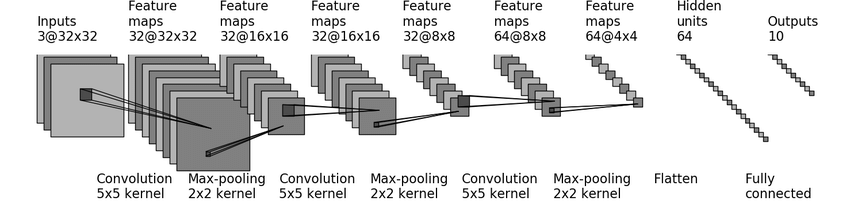

In [49]:
cnn = CNN(INPUT_DIM, OUTPUT_DIM)
cnn = cnn.to(device)
count_model_params(cnn)

145578

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)

cnn_train_losses, cnn_val_losses = train(cnn, NUM_EPOCHS, train_loader, eval_loader, device, criterion, optimizer)

Epoch 59 Iteration 49: loss 0.42198. : 100%|████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 10.97it/s]


Epoch 100 Iteration 49: loss 0.15790. : 100%|███████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 11.07it/s]


In [38]:
save_model_config(cnn)

saved to models/checkpoint_01-56_22-04-2025.pth


## Task 2 Analysis

  - Compare the performance of both models: investigate their learning curves (train/eval loss), compare their test accuracy, and compute their confusion matrix
  - Visualize some images, along with the predictions from your models. In what images do your models fail more often? Why do you think so?

In [11]:
for class_count in range(OUTPUT_DIM):
    print(f"occurencies of label={class_count}: train={train_loader.dataset.targets.count(class_count)}, test={eval_loader.dataset.targets.count(class_count)}")

occurencies of label=0: train=5000, test=1000
occurencies of label=1: train=5000, test=1000
occurencies of label=2: train=5000, test=1000
occurencies of label=3: train=5000, test=1000
occurencies of label=4: train=5000, test=1000
occurencies of label=5: train=5000, test=1000
occurencies of label=6: train=5000, test=1000
occurencies of label=7: train=5000, test=1000
occurencies of label=8: train=5000, test=1000
occurencies of label=9: train=5000, test=1000


Based on the occurencies output, we confirm that the dataset is balanced.

### MLP

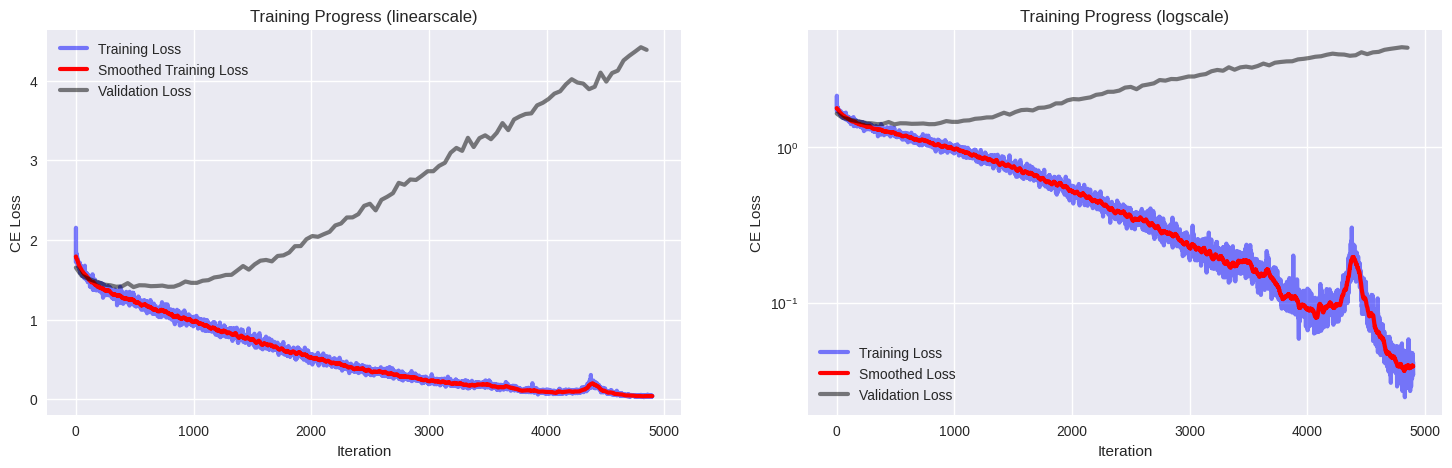

In [17]:
plot_learning_curve(mlp_losses[0], mlp_losses[1], len(mlp_losses[0])//len(mlp_losses[1]))

Based on the learning curves, after around 500th iteration, we can observe an increase of the validation loss curve, which indicates the start of overfitting.

In [30]:
mlp_confmat = MulticlassConfusionMatrix(num_classes=OUTPUT_DIM).to(device)
mlp_metrics = evaluate(mlp, eval_loader, device, mlp_confmat)

print(mlp_metrics)

100%|██████████| 10/10 [00:00<00:00, 12.44it/s]

{'accuracy': 50.36000000000001, 'confusion_matrix': MulticlassConfusionMatrix()}


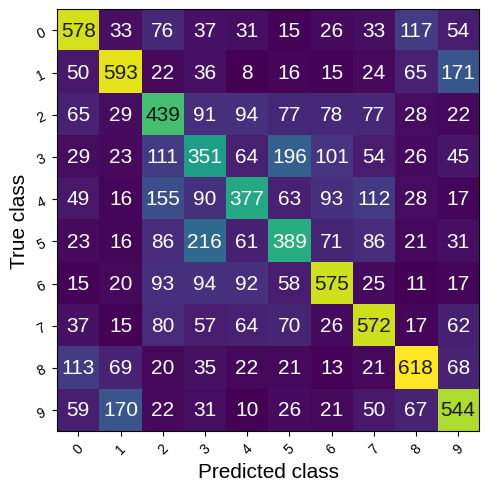

In [19]:
fig_, ax_ = metrics['confusion_matrix'].plot()

The worst predictions are for classes with least diagonal values. For class label 3 there were only 351 out of 1000 correct prediction, and a significant portion (almost 20%) was labeled with class label 5. Class labels 4 and 5 are also often misslabeled.

In [36]:
for i, class_label in enumerate(CLASSES):
    print(f"{i} -> {class_label}")

0 -> airplane
1 -> automobile
2 -> bird
3 -> cat
4 -> deer
5 -> dog
6 -> frog
7 -> horse
8 -> ship
9 -> truck


The model often struggles to distinguish between cats and dogs. The reason might be that they are both animals and have similar features in appearence.

490 missclassified images in the first test batch


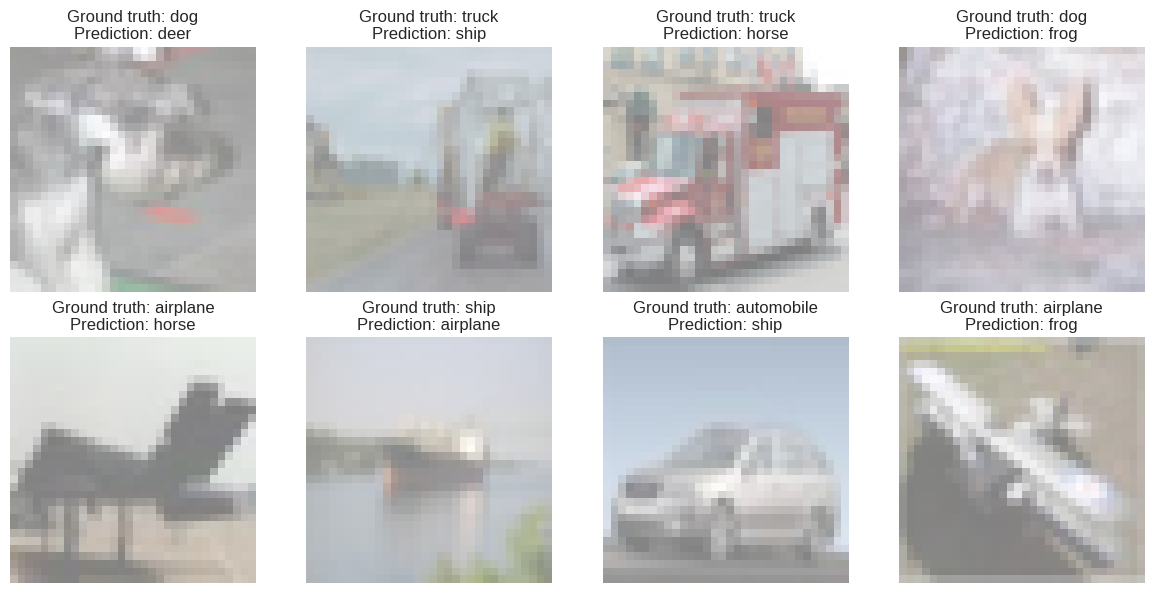

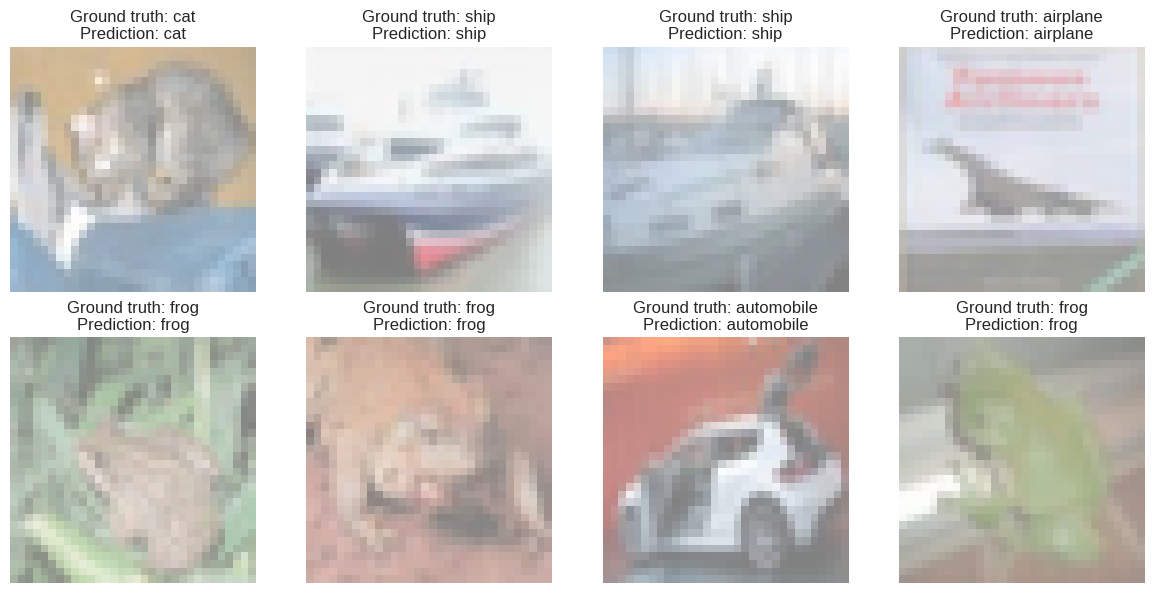

In [24]:
first_batch = next(iter(eval_loader))
images, targets = first_batch
targets = targets.cpu()
predictions = mlp(images.to(device)).argmax(dim=1).cpu()
images = images.cpu()

# take failed samples from the batch
diff_indices = np.where(targets != predictions)[0]
print(f"{len(diff_indices)} missclassified images in the first test batch")
sample_ids = diff_indices[len(diff_indices)//2:]

plot_images(images[sample_ids], targets[sample_ids].cpu(), predictions[sample_ids].cpu(), CLASSES)
plot_images(images, targets.cpu(), predictions.cpu(), CLASSES)

### CNN

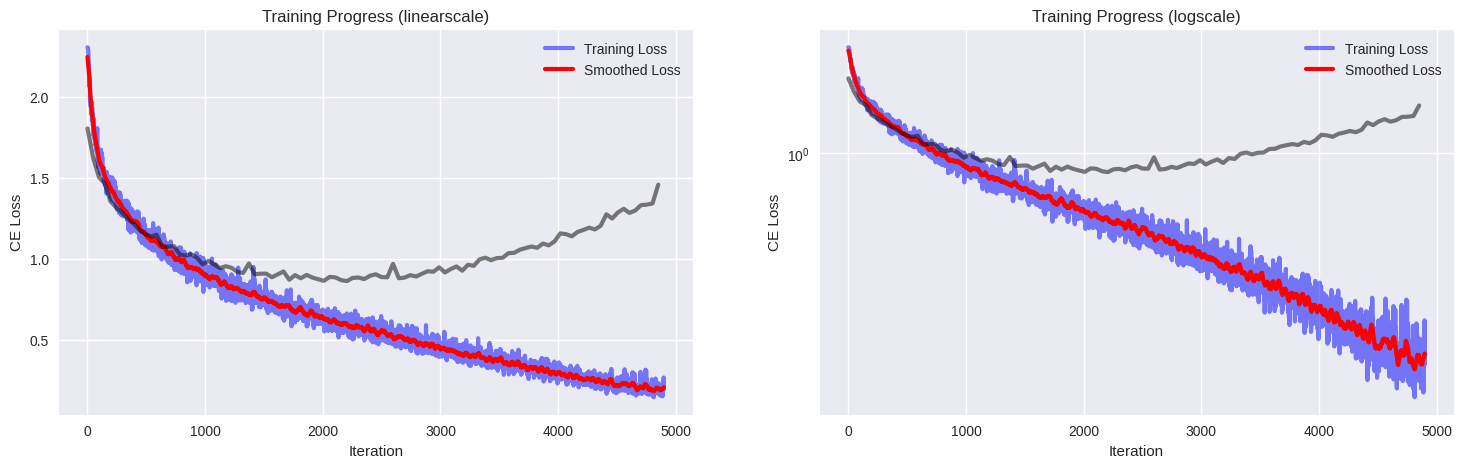

In [53]:
plot_learning_curve(cnn_train_losses, cnn_val_losses, len(cnn_train_losses)//len(cnn_val_losses))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59it/s]


{'accuracy': 68.34, 'confusion_matrix': MulticlassConfusionMatrix()}


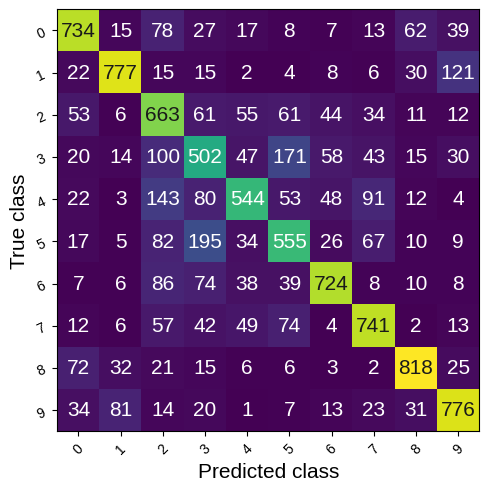

In [51]:
cnn_confmat = MulticlassConfusionMatrix(num_classes=OUTPUT_DIM).to(device)
cnn_metrics = evaluate(cnn, eval_loader, device, cnn_confmat)
print(cnn_metrics)
fig_, ax_ = cnn_metrics['confusion_matrix'].plot()

## Task 3 Mitigate Overfitting

  - Train both models with and without DropOut. Compare the results: training and validation loss, accuracy, ...
  - Implement and use **your own** custom learning rate warmup and learning rate scheduler criterion to avoid overfitting.<br>
    It is not allowed to use PyTorch's schedulers, but you should code your own.<br>
    Train **one model** using it and show whether you can mitigate overfitting.

### MLP

In [25]:
INPUT_DIM = np.prod(train_dataset.data.shape[-3:]) # 32*32*3
OUTPUT_DIM = len(set(train_dataset.targets)) # 10

hidden_dim = int((INPUT_DIM + OUTPUT_DIM) * 2/3) # 2/3 rule
print(f"input dim={INPUT_DIM}, output dim={OUTPUT_DIM}, hidden={hidden_dim}")

input dim=3072, output dim=10, hidden=2054


In [26]:
mlp_with_dropout = MLP(INPUT_DIM, hidden_dim, OUTPUT_DIM, use_dropout=True)
mlp_with_dropout = mlp_with_dropout.to(device)

mlp_with_dropout_criterion = nn.CrossEntropyLoss()
mlp_with_dropout_optimizer = torch.optim.Adam(mlp_with_dropout.parameters(), lr=LR)

mlp_with_dropout_losses = train(mlp_with_dropout, NUM_EPOCHS, train_loader, eval_loader,
                                device, mlp_with_dropout_criterion, mlp_with_dropout_optimizer)

Epoch 100 Iteration 49: loss 1.01800. : 100%|██████████| 49/49 [00:04<00:00, 11.88it/s]


In [35]:
confmat_mlp_with_dropout = MulticlassConfusionMatrix(num_classes=OUTPUT_DIM).to(device)
metrics_mlp_with_dropout = evaluate(mlp_with_dropout, eval_loader, device, confmat_mlp_with_dropout)

print(metrics_mlp_with_dropout)

  0%|          | 0/10 [00:00<?, ?it/s]100%|██████████| 10/10 [00:00<00:00, 11.82it/s]

{'accuracy': 55.779999999999994, 'confusion_matrix': MulticlassConfusionMatrix()}


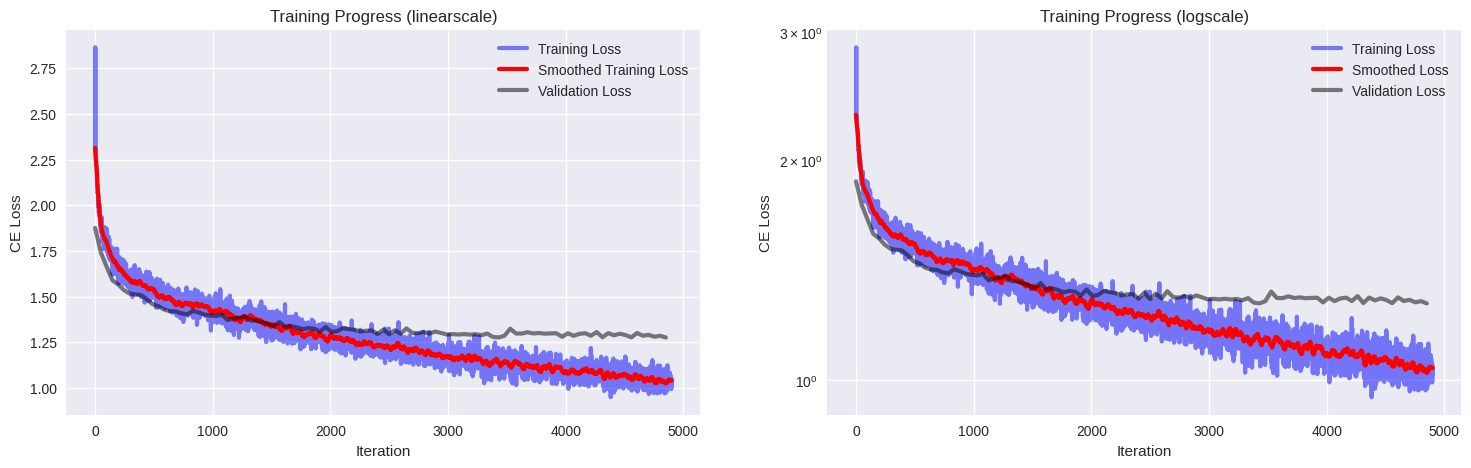

In [36]:
plot_learning_curve(mlp_with_dropout_losses[0], mlp_with_dropout_losses[1], len(mlp_with_dropout_losses[0])//len(mlp_with_dropout_losses[1]))

In [37]:
save_model_config(mlp, 'dropout_mlp')

saved to models/dropout_mlp_09-02_22-04-2025.pth


### Training with Learning Rate Scheduler

In [38]:
# define new model
mlp_with_scheduler = MLP(INPUT_DIM, hidden_dim, OUTPUT_DIM, use_dropout=True)
mlp_with_scheduler = mlp_with_scheduler.to(device)

# criterion, optimizer
mlp_with_scheduler_criterion = nn.CrossEntropyLoss()
mlp_with_scheduler_optimizer = torch.optim.Adam(mlp_with_scheduler.parameters(), lr=LR)

WARMUP_EPOCHS = 5

# apply cosine rate decay after warmup phase
decay_func=lambda e: cosine_decay(e, epochs=(NUM_EPOCHS - WARMUP_EPOCHS))
lr_scheduler_mlp = LearningRateScheduler(LR, mlp_with_scheduler_optimizer, decay_func, WARMUP_EPOCHS)

In [39]:
# train the model
mlp_with_scheduler_losses = train(mlp_with_scheduler, NUM_EPOCHS, train_loader, eval_loader, device,
                                  mlp_with_scheduler_criterion, mlp_with_scheduler_optimizer, lr_scheduler_mlp)

# evaluation
confmat_with_scheduler = MulticlassConfusionMatrix(num_classes=OUTPUT_DIM).to(device)
metrics_with_scheduler = evaluate(mlp_with_scheduler, eval_loader, device, confmat_with_scheduler)
print(metrics_with_scheduler)

100%|██████████| 10/10 [00:00<00:00, 10.94it/s]

{'accuracy': 55.66, 'confusion_matrix': MulticlassConfusionMatrix()}


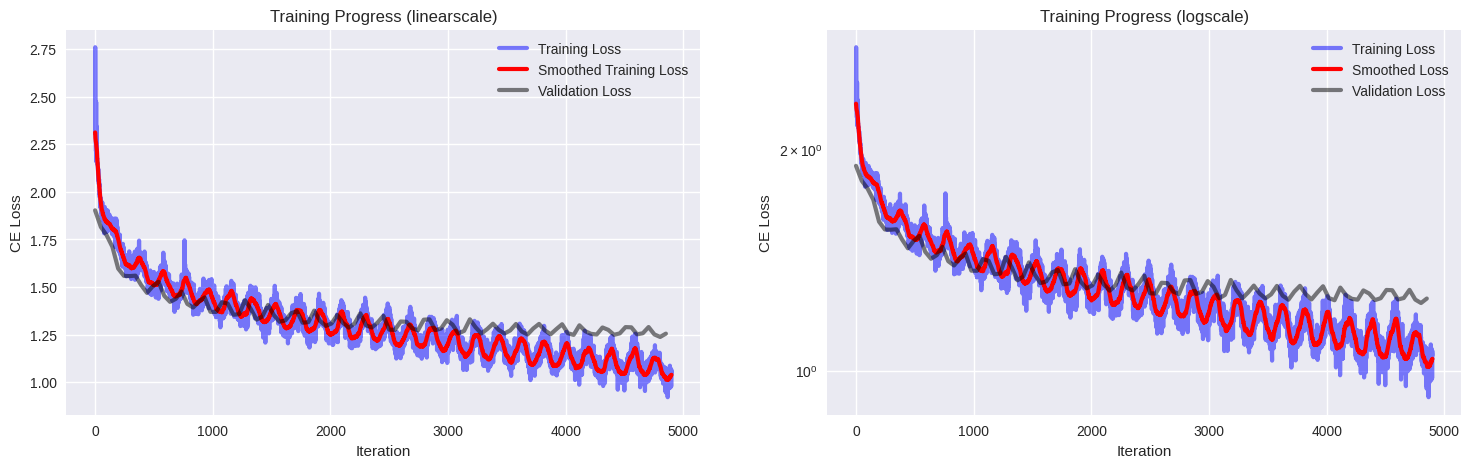

In [40]:
plot_learning_curve(mlp_with_scheduler_losses[0], mlp_with_scheduler_losses[1], len(mlp_with_scheduler_losses[0])//len(mlp_with_scheduler_losses[1]))

In [41]:
save_model_config(mlp, 'scheduled_mlp')

saved to models/scheduled_mlp_09-11_22-04-2025.pth


#### Conclusions

In [42]:
print(f"Statistics")
print(f"accuracy for standard MLP: {mlp_metrics['accuracy']}")
print(f"accuracy for MLP with dropout: {metrics_mlp_with_dropout['accuracy']}")
print(f"accuracy for MLP with scheduler: {metrics_with_scheduler['accuracy']}")

Statistics
accuracy for standard MLP: 50.36000000000001
accuracy for MLP with dropout: 55.779999999999994
accuracy for MLP with scheduler: 55.66


We observe that techniques with dropout and scheduler do contribute to the accuracy improvement in the case of multilayer perceptron

### CNN

In [29]:
INPUT_DIM = train_dataset.data.shape[-3:]
OUTPUT_DIM = len(set(train_dataset.targets)) # 10

print(f"input dim={INPUT_DIM}, output dim={OUTPUT_DIM}")

input dim=(32, 32, 3), output dim=10


#### Dropout

In [30]:
cnn_with_dropout = CNN(INPUT_DIM, OUTPUT_DIM, True)
cnn_with_dropout = cnn_with_dropout.to(device)

cnn_with_dropout_criterion = nn.CrossEntropyLoss()
cnn_with_dropout_optimizer = torch.optim.Adam(cnn_with_dropout.parameters(), lr=LR)

cnn_with_dropout_losses = train(cnn_with_dropout, NUM_EPOCHS, train_loader, eval_loader,
                                device, cnn_with_dropout_criterion, cnn_with_dropout_optimizer)

Epoch 59 Iteration 49: loss 1.21771. : 100%|████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 10.96it/s]


Epoch 100 Iteration 49: loss 1.16736. : 100%|███████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 11.09it/s]


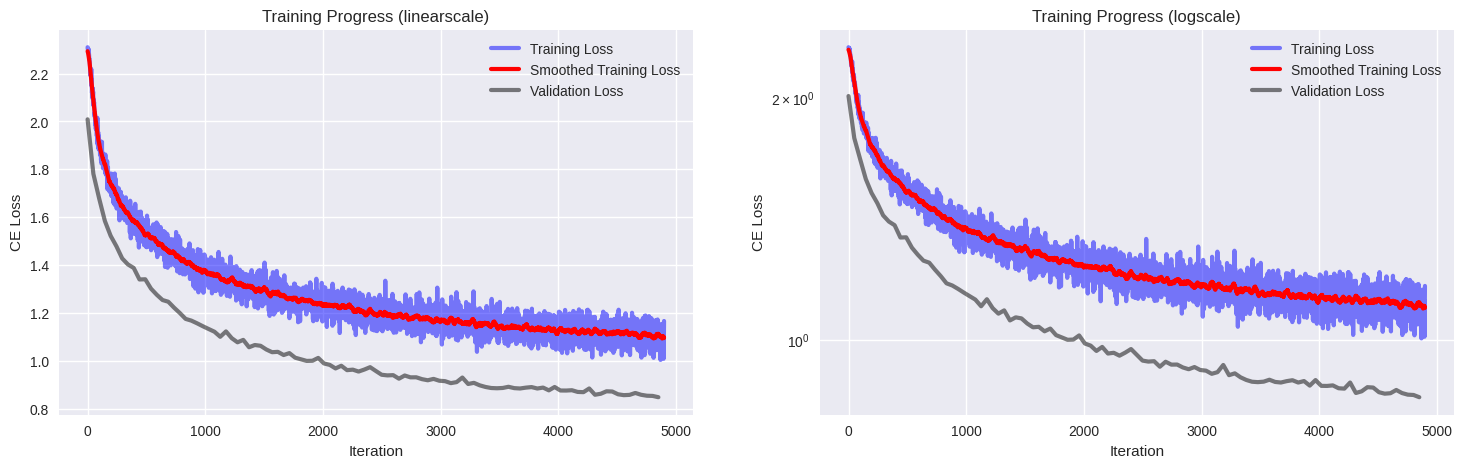

In [31]:
plot_learning_curve(cnn_with_dropout_losses[0], cnn_with_dropout_losses[1], len(cnn_with_dropout_losses[0])//len(cnn_with_dropout_losses[1]))

In [39]:
cnn_with_dropout_confmat = MulticlassConfusionMatrix(num_classes=OUTPUT_DIM).to(device)
cnn_with_dropout_metrics = evaluate(cnn_with_dropout, eval_loader, device, cnn_with_dropout_confmat)

print(cnn_with_dropout_metrics)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67it/s]

{'accuracy': 70.58, 'confusion_matrix': MulticlassConfusionMatrix()}


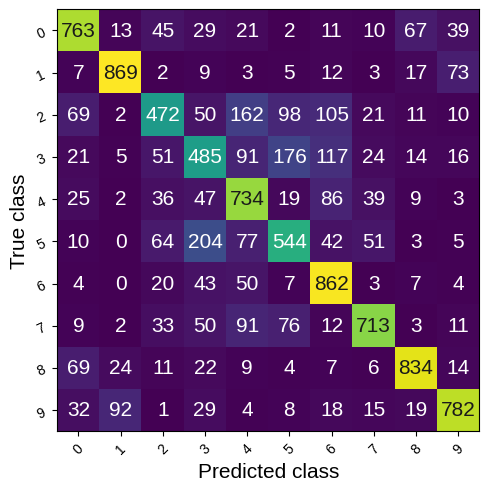

In [40]:
fig_, ax_ = cnn_with_dropout_metrics['confusion_matrix'].plot()

The perfomance of the model is way better in comparison to the version without dropout (68.34%), however it still struggles when classifying cats and dogs (classes 3 and 5)

#### Learning Rate Scheduler

In [37]:
cnn_with_lr = CNN(INPUT_DIM, OUTPUT_DIM)
cnn_with_lr = cnn_with_lr.to(device)

cnn_with_lr_criterion = nn.CrossEntropyLoss()
cnn_with_lr_optimizer = torch.optim.Adam(cnn_with_lr.parameters(), lr=LR)


WARMUP_EPOCHS = 5

# apply cosine rate decay after warmup phase
decay_func=lambda e: cosine_decay(e, epochs=(NUM_EPOCHS - WARMUP_EPOCHS))
lr_scheduler = LearningRateScheduler(LR, cnn_with_lr_optimizer, decay_func, WARMUP_EPOCHS)

cnn_with_lr_losses = train(cnn_with_lr, NUM_EPOCHS, train_loader, eval_loader, device, 
                           cnn_with_lr_criterion, cnn_with_lr_optimizer, lr_scheduler)

Epoch 59 Iteration 49: loss 0.78177. : 100%|████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 11.07it/s]


Epoch 100 Iteration 49: loss 0.43315. : 100%|███████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 11.19it/s]


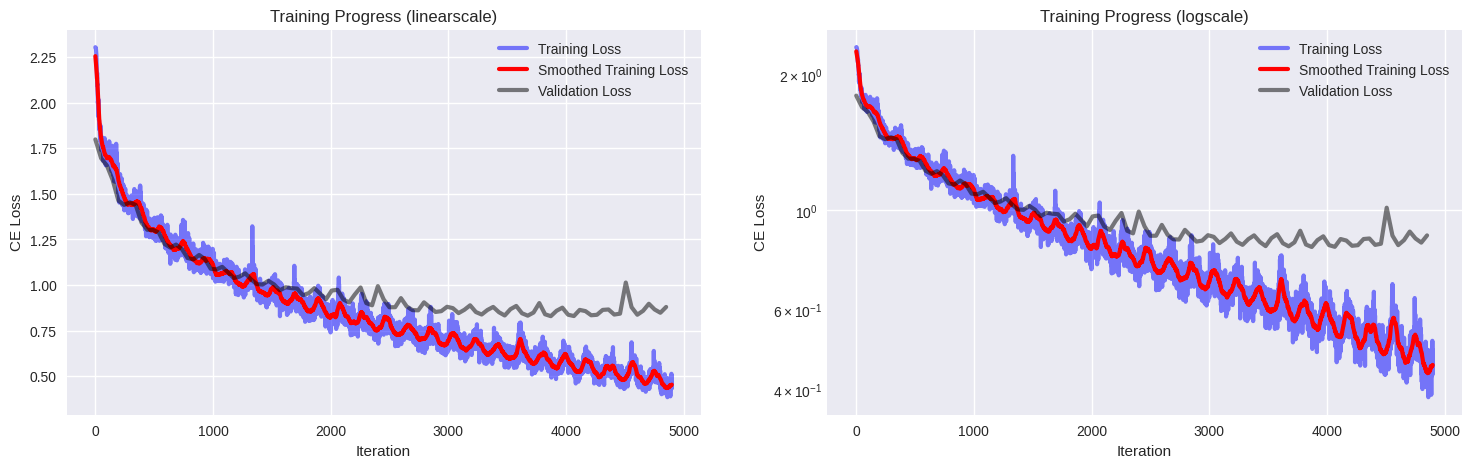

In [38]:
plot_learning_curve(cnn_with_lr_losses[0], cnn_with_lr_losses[1], len(cnn_with_lr_losses[0])//len(cnn_with_lr_losses[1]))

In this case, we still observe overfitting: the validation loss plateaus while training loss continues to decrease.
This suggests that the learning rate scheduler is not aggressive enough in reducing the learning rate.

In [41]:
cnn_with_lr_confmat = MulticlassConfusionMatrix(num_classes=OUTPUT_DIM).to(device)
cnn_with_lr_metrics = evaluate(cnn_with_lr, eval_loader, device, cnn_with_lr_confmat)

print(cnn_with_lr_metrics)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67it/s]

{'accuracy': 72.31, 'confusion_matrix': MulticlassConfusionMatrix()}


The accuracy is higher than in case with dropout

## Task 4 Extra Point

Extra Point:
- Train and evaluated ONE of the following:
    MLP-Mixer: https://openreview.net/pdf?id=EI2KOXKdnP
    ConvMixer: https://arxiv.org/abs/2201.09792
- Compare it with your MLP and CNN models
- Does it work better? Why or why not?

In [43]:
LR = 1e-3

INPUT_DIM = train_dataset.data.shape[-3:]

conv_mixer = ConvMixer(input_dim=INPUT_DIM, depth=8)
conv_mixer = conv_mixer.to(device)
count_model_params(conv_mixer)

2353

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(conv_mixer.parameters(), lr=LR)

conv_mixer_losses = train(conv_mixer, NUM_EPOCHS, train_loader, eval_loader, device, criterion, optimizer)

Epoch 59 Iteration 49: loss 1.52984. : 100%|████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 10.50it/s]


Epoch 100 Iteration 49: loss 1.51446. : 100%|███████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 10.50it/s]


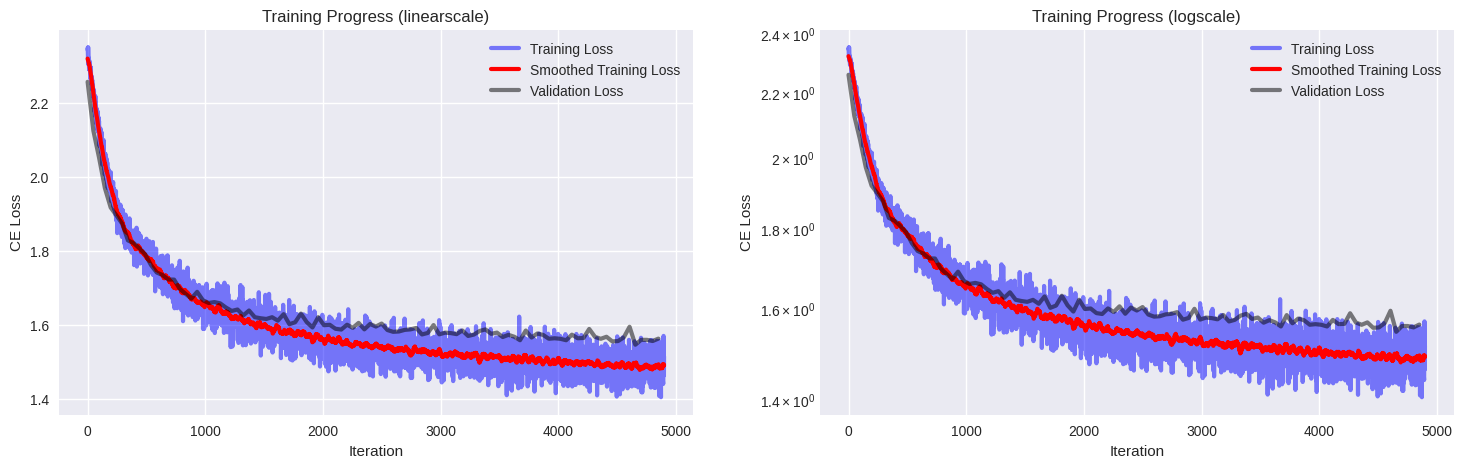

In [45]:
plot_learning_curve(conv_mixer_losses[0], conv_mixer_losses[1], len(conv_mixer_losses[0])//len(conv_mixer_losses[1]))

The model might benefit from additional training epochs to fully converge, but there's also an indication of early overfitting. This also can be the case that the model is too simple for the dataset - it contains only 2353 parameters.

597 missclassified images in the first test batch


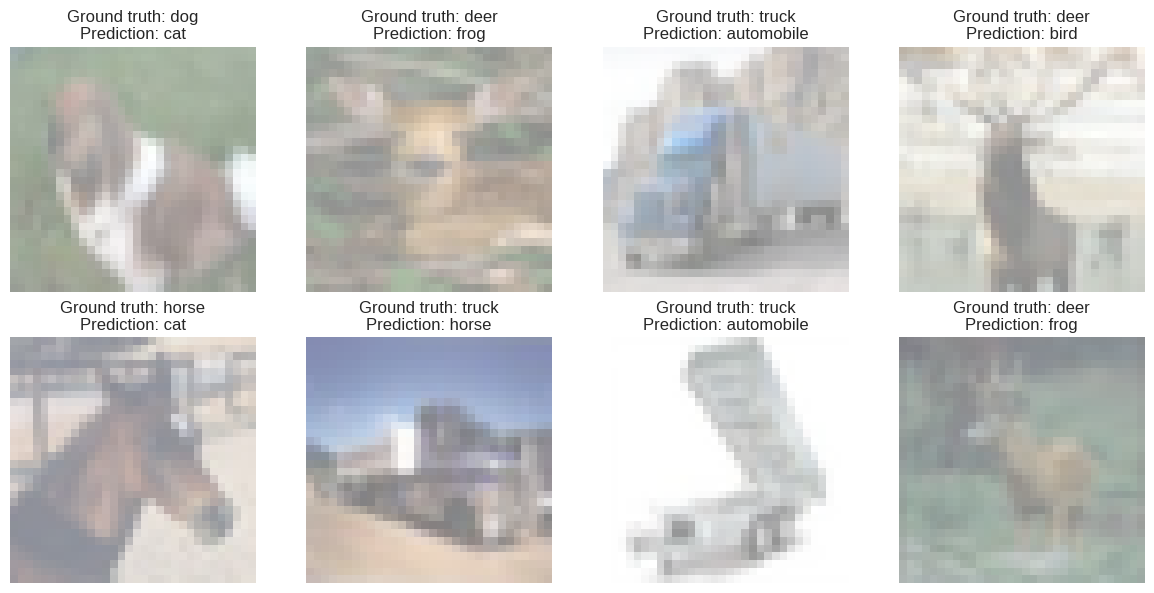

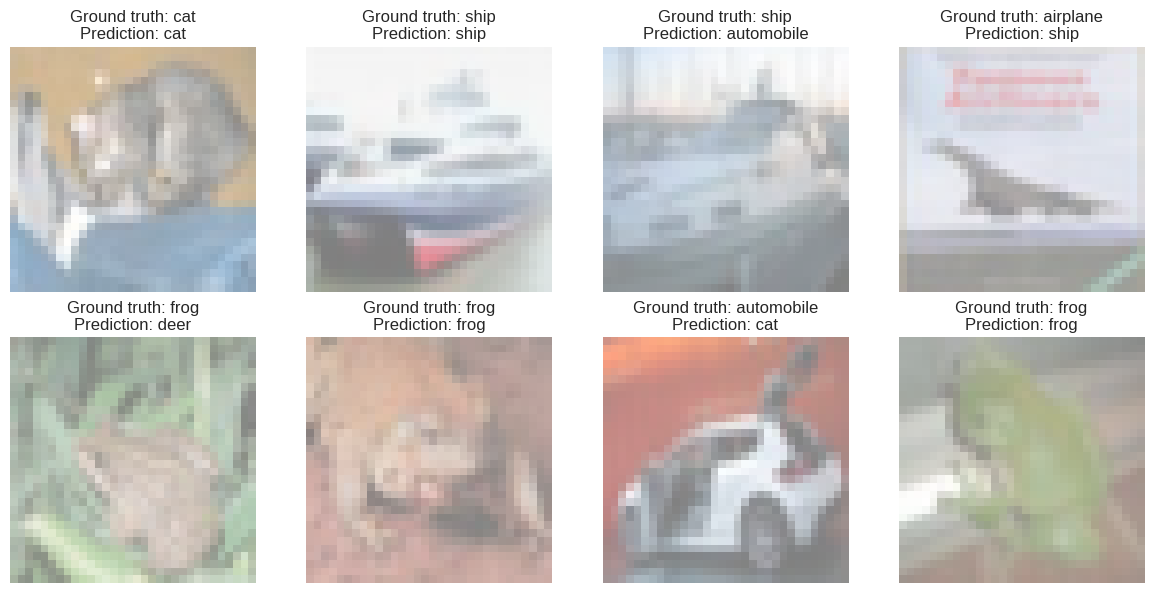

In [46]:
first_batch = next(iter(eval_loader))
images, targets = first_batch
targets = targets.cpu()
predictions = conv_mixer(images.to(device)).argmax(dim=1).cpu()
images = images.cpu()

# take failed samples from the batch
diff_indices = np.where(targets != predictions)[0]
print(f"{len(diff_indices)} missclassified images in the first test batch")
sample_ids = diff_indices[len(diff_indices)//2:]

plot_images(images[sample_ids], targets[sample_ids].cpu(), predictions[sample_ids].cpu(), CLASSES)
plot_images(images, targets.cpu(), predictions.cpu(), CLASSES)

In [47]:
conv_mixer_confmat = MulticlassConfusionMatrix(num_classes=OUTPUT_DIM).to(device)
conv_mixer_metrics = evaluate(conv_mixer, eval_loader, device, conv_mixer_confmat)

print(conv_mixer_metrics)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37it/s]

{'accuracy': 42.34, 'confusion_matrix': MulticlassConfusionMatrix()}


The accuracy is lower compared to previous models — only 42.34%.
This is likely because the ConvMixer model has not been sufficiently trained yet. The learning curve suggests that more training epochs are needed for the model to converge and generalize better.